In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time, warnings, pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import edward as ed
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from edward.models import Normal, Categorical, Dirichlet, InverseGamma, MultivariateNormalDiag, ParamMixture
warnings.simplefilter('ignore')

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
def build_toy_dataset():
    features = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
    df = pd.read_csv('../winequality-white.csv', sep=';')
    X = df[features].values
    y = (df.quality >= 7).values.astype(np.float32)

    # 标准化处理
    scaler = StandardScaler()
    X = scaler.fit_transform(X).astype(np.float32)
    return X, y

def neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = tf.tanh(tf.matmul(X, W_0) + b_0)
    h = tf.tanh(tf.matmul(h, W_1) + b_1)
    h = tf.matmul(h, W_2) + b_2
    return tf.reshape(h, [-1])

def pack_theta( W_0, W_1, W_2, b_0, b_1, b_2):
    pW_0 = tf.reshape(W_0, [-1])
    pW_1 = tf.reshape(W_1, [-1])
    pW_2 = tf.reshape(W_2, [-1])
    pb_0 = tf.reshape(b_0, [-1])
    pb_1 = tf.reshape(b_1, [-1])
    pb_2 = tf.reshape(b_2, [-1])
    return tf.concat(values=[pW_0, pW_1, pW_2, pb_0, pb_1, pb_2], axis=0)

In [3]:
#ed.set_seed(42)
layer_size = [11, 7, 10, 1]
J = 1000
B = 500
K = 20
# DATA
X_train, y_train = build_toy_dataset() #真实数据
N, D = X_train.shape
print(N, D)

4898 11


In [4]:
# MODEL
'''
W_0 = Normal(loc=tf.zeros([D, 7]), scale=10 * tf.ones([D, 7]),name="W_0")
W_1 = Normal(loc=tf.zeros([7, 10]), scale=10 * tf.ones([7, 10]), name="W_1")
W_2 = Normal(loc=tf.zeros([10, 1]), scale=10 * tf.ones([10, 1]), name="W_2")
b_0 = Normal(loc=tf.zeros(7), scale=10 * tf.ones(7), name="b_0")
b_1 = Normal(loc=tf.zeros(10), scale=10 * tf.ones(10), name="b_1")
b_2 = Normal(loc=tf.zeros(1), scale=10 * tf.ones(1), name="b_2")
'''
C = 2
with tf.variable_scope("W_0"):
    probs = Dirichlet(tf.ones(C))
    mu = Normal(tf.zeros([D, 7]), tf.ones([D, 7]), sample_shape=C)
    sigmasq = InverseGamma(tf.ones([D, 7]), tf.ones([D, 7]), sample_shape=C)
    W_0 = ParamMixture(probs, {'loc': mu, 'scale_diag': 10*tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
    
W_0 = MixtureSameFamily(
    mixture_distribution=Categorical(
        probs=Dirichlet(tf.ones(C))),
    components_distribution=Normal(
      loc=[tf.zeros([D, 7]) for _ in range(C)],       # One for each component.
      scale=[10 * tf.ones([D, 7]) for _ in range(C)]), name="W_0")  # And same here.
W_1 = MixtureSameFamily(
    mixture_distribution=Categorical(
        probs=Dirichlet(tf.ones(C))),
    components_distribution=Normal(
      loc=[tf.zeros([7, 10]) for _ in range(C)],
      scale=[10 * tf.ones([7, 10]) for _ in range(C)]), name="W_1")
W_2 = MixtureSameFamily(
    mixture_distribution=Categorical(
        probs=Dirichlet(tf.ones(C))),
    components_distribution=Normal(
      loc=[tf.zeros([10, 1]) for _ in range(C)],
      scale=[10 * tf.ones([10, 1]) for _ in range(C)]), name="W_2")
b_0 = MixtureSameFamily(
    mixture_distribution=Categorical(
        probs=Dirichlet(tf.ones(C))),
    components_distribution=Normal(
      loc=[tf.zeros(7) for _ in range(C)],
      scale=[10 * tf.ones(7) for _ in range(C)]), name="b_0")
b_1 = MixtureSameFamily(
    mixture_distribution=Categorical(
        probs=Dirichlet(tf.ones(C))),
    components_distribution=Normal(
      loc=[tf.zeros(10) for _ in range(C)],
      scale=[10 * tf.ones(10) for _ in range(C)]), name="b_1")
b_2 = MixtureSameFamily(
    mixture_distribution=Categorical(
        probs=Dirichlet(tf.ones(C))),
    components_distribution=Normal(
      loc=[tf.zeros(1) for _ in range(C)],
      scale=[10 * tf.ones(1) for _ in range(C)]), name="b_2")

X = tf.placeholder(tf.float32, [N, D], name="X")
y = Normal(loc=neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2), scale=0.1 * tf.ones(N), name="y")

ValueError: Dimensions must be equal, but are 4898 and 2 for 'W_0/ParamMixture/sample/mul' (op: 'Mul') with input shapes: [4898,2,11,7], [2,4898,1,1].

In [2]:
help(tf.get_variable)

NameError: name 'tf' is not defined

In [9]:
# INFERENCE FRAMEWORK
with tf.variable_scope("qW_0"):
    probs = tf.get_variable("probs", [C,], initializer=tf.constant_initializer(1.0 / C))
    loc = tf.get_variable("loc", [D, 7])
    scale = tf.nn.softplus(tf.get_variable("scale", [D, 7]))
    qW_0 = MixtureSameFamily(
        mixture_distribution=Categorical(
            probs=probs),
        components_distribution=Normal(
            loc=[loc for _ in range(C)], 
            scale=[scale for _ in range(C)]))
with tf.variable_scope("qW_1"):
    probs = tf.get_variable("probs", [C,], initializer=tf.constant_initializer(1.0 / C))
    loc = tf.get_variable("loc", [7, 10])
    scale = tf.nn.softplus(tf.get_variable("scale", [7, 10]))
    qW_1 = MixtureSameFamily(
        mixture_distribution=Categorical(
            probs=probs),
        components_distribution=Normal(
            loc=[loc for _ in range(C)], 
            scale=[scale for _ in range(C)]))
with tf.variable_scope("qW_2"):
    probs = tf.get_variable("probs", [C,], initializer=tf.constant_initializer(1.0 / C))
    loc = tf.get_variable("loc", [10, 1])
    scale = tf.nn.softplus(tf.get_variable("scale", [10, 1]))
    qW_2 = MixtureSameFamily(
        mixture_distribution=Categorical(
            probs=probs),
        components_distribution=Normal(
            loc=[loc for _ in range(C)], 
            scale=[scale for _ in range(C)]))
with tf.variable_scope("qb_0"):
    probs = tf.get_variable("probs", [C,], initializer=tf.constant_initializer(1.0 / C))
    loc = tf.get_variable("loc", [7])
    scale = tf.nn.softplus(tf.get_variable("scale", [7]))
    qb_0 = MixtureSameFamily(
        mixture_distribution=Categorical(
            probs=probs),
        components_distribution=Normal(
            loc=[loc for _ in range(C)], 
            scale=[scale for _ in range(C)]))
with tf.variable_scope("qb_1"):
    probs = tf.get_variable("probs", [C,], initializer=tf.constant_initializer(1.0 / C))
    loc = tf.get_variable("loc", [10])
    scale = tf.nn.softplus(tf.get_variable("scale", [10]))
    qb_1 = MixtureSameFamily(
        mixture_distribution=Categorical(
            probs=probs),
        components_distribution=Normal(
            loc=[loc for _ in range(C)], 
            scale=[scale for _ in range(C)]))
with tf.variable_scope("qb_2"):
    probs = tf.get_variable("probs", [C,], initializer=tf.constant_initializer(1.0 / C))
    loc = tf.get_variable("loc", [1])
    scale = tf.nn.softplus(tf.get_variable("scale", [1]))
    qb_2 = MixtureSameFamily(
        mixture_distribution=Categorical(
            probs=probs),
        components_distribution=Normal(
            loc=[loc for _ in range(C)], 
            scale=[scale for _ in range(C)]))

ValueError: `mixture_distribution components` (2) does not equal `components_distribution.batch_shape[-1]` (7)

In [7]:
# Sample functions from variational model to visualize fits.
mus = tf.stack(
    [neural_network(X_train, qW_0.sample(), qW_1.sample(), qW_2.sample(),
                       qb_0.sample(), qb_1.sample(), qb_2.sample())
    for _ in range(B)])
'''
mus = tf.stack(
    [pack_theta(qW_0.sample(), qW_1.sample(),
                       qb_0.sample(), qb_1.sample())
    for _ in range(B)])'''

'\nmus = tf.stack(\n    [pack_theta(qW_0.sample(), qW_1.sample(),\n                       qb_0.sample(), qb_1.sample())\n    for _ in range(B)])'

initializing the graph...
sampleing from prior of theta...
sampling time:  19.5237498283


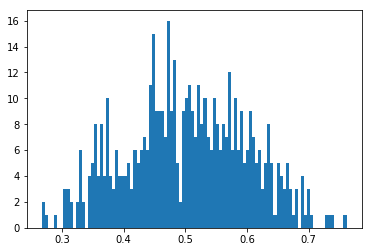

In [8]:
print("initializing the graph...")
start_sample = time.time()
sess = ed.get_session()
tf.global_variables_initializer().run()
print("sampleing from prior of theta...")
outputs = mus.eval()
print("sampling time: ", time.time() - start_sample)

s = []
for i in range(B):
    s.append(roc_auc_score(y_train,outputs[i]))
    
plt.hist(s, bins=100)
plt.show()

In [9]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data={X: X_train, y: y_train})
inference.run(n_iter=J, n_samples=K)

1000/1000 [100%] ██████████████████████████████ Elapsed: 40s | Loss: 26516.486


In [12]:
outputs.shape

(100, 4898)

sampleing from posterior of theta...
sampling time:  0.329385042191


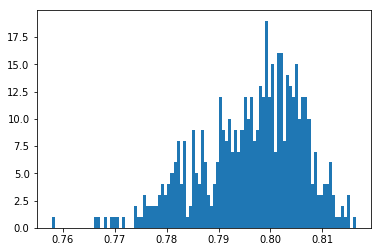

In [10]:
print("sampleing from posterior of theta...")
start_sample = time.time()
outputs = mus.eval()
print("sampling time: ", time.time() - start_sample)
sp = []
for i in range(B):
    sp.append(roc_auc_score(y_train,outputs[i]))
    
plt.hist(sp, bins=100)
plt.show()

In [2]:
import pickle
outputs = mus.eval()
with open('../smc2/theta'+'-'+str(J)+'-'+str(B),'wb') as f:
    pickle.dump(outputs, f)

NameError: name 'mus' is not defined

In [3]:
J = 5000
B = 5000
with open('../smc2/theta'+'-'+str(J)+'-'+str(B)+'-2h-10v','rb') as f:
    outputs1 = np.array(pickle.load(f))

IOError: [Errno 2] No such file or directory: '../smc2/theta-5000-5000-2h-10v'

(4500, 183)

In [6]:
def np_neural_network(X, W_0, W_1, b_0, b_1):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.matmul(h, W_1) + b_1
    return np.reshape(h, [-1])

def unpack_thete_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:11*14], [11, 14])
    W_1 = np.reshape(theta[11*14: 11*14+14*1], [14, 1])
    b_0 = np.reshape(theta[11*14+14*1:11*14+14*1+14], [14])
    b_1 = np.reshape(theta[11*14+14*1+14:], [1])
    return np_neural_network(X, W_0, W_1, b_0, b_1)

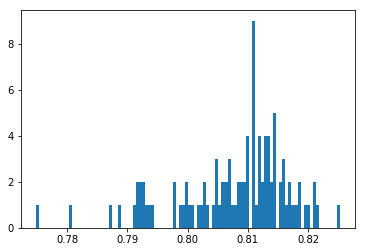

In [7]:
sp = []
for theta in outputs1:
    sp.append(roc_auc_score(y_train,unpack_thete_get_outputs(X_train, theta)))
plt.hist(sp, bins=100)
plt.show()

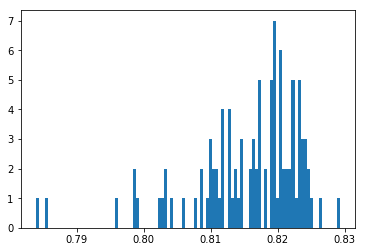

In [22]:
sp = []
for i in range(B):
    sp.append(roc_auc_score(y_train,unpack_thete_get_outputs(X_train, outputs[i])))
plt.hist(sp, bins=100)
plt.show()

In [12]:
plt.savefig

(1000, 11, 14)

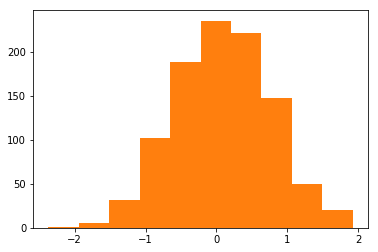

In [14]:
plt.hist(mya[:,0,0])
plt.show()

In [ ]:
saver = tf.train.Saver([])
with tf.Session() as sess:
    saver.